In [1]:
import os
import cv2
import glob
from glob import glob
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from IPython.display import display
import keras

Using TensorFlow backend.


In [2]:
def show(X):
    display(Image.fromarray(X))
    
def im_multi(path):
    try:
        #print(path)
        im_stats_im_ = cv2.imread(path)
        #print(im_stats_im_.size)
        return [path, {'size': im_stats_im_.size}]
    except:
        print("Error path:%s"%(path))
        return [path, {'size': [0, 0]}]
    
def im_stats(im_stats_df):
    im_stats_d = {}
    p = Pool(cpu_count())
    ret = p.map(im_multi, im_stats_df['path'])
    for i in range(len(ret)):
        im_stats_d[ret[i][0]] = ret[i][1]
    im_stats_df['size'] = im_stats_df['path'].map(lambda x: ' '.join([str(s) for s in str(im_stats_d[x]['size'])]))
    return im_stats_df

def get_im_cv2(args):
    img = cv2.imread(args[0])
    resized = cv2.resize(img, (args[1], args[1]), cv2.INTER_LINEAR)
    return [args[0], resized]

def image_features(paths, dim):
    imf_d = {}
    p = Pool(cpu_count())
    dims = [dim for i in range(len(paths.tolist()))]
    params = list(zip(paths.tolist(), dims))
    ret = p.map(get_im_cv2, params)
    for i in range(len(ret)):
        imf_d[ret[i][0]] = ret[i][1]
    ret = []
    fdata = [imf_d[f] for f in paths]
    fdata = np.array(fdata, dtype = np.uint8)
    return fdata

In [3]:
all_cervix_images = []

basepath = '/home/dataset/train/'
for path in sorted(glob(basepath + "*")):
    #print(path)
    cervix_type = path.split("/")[-1]
    #print(cervix_type)
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    #print(cervix_images)
    all_cervix_images = all_cervix_images + cervix_images

basepath = '/home/dataset/Type_'
for path in sorted(glob(basepath + "*")):
    #print(path)
    cervix_type = path.split("/")[-1][-1]
    #print(cervix_type)
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    #print(cervix_images)
    all_cervix_images = all_cervix_images + cervix_images

In [4]:
all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,/home/dataset/train/Type_1/0.jpg,jpg,Type_1
1,/home/dataset/train/Type_1/10.jpg,jpg,Type_1
2,/home/dataset/train/Type_1/1013.jpg,jpg,Type_1
3,/home/dataset/train/Type_1/1014.jpg,jpg,Type_1
4,/home/dataset/train/Type_1/1019.jpg,jpg,Type_1


In [5]:
import glob
train1 = glob.glob('/home/dataset/train/**/*.jpg')
train1 =\
pd.DataFrame([[p.split('/')[4],p.split('/')[5],p] for p in train1], columns = ['type','image','path'])

train2 = glob.glob('/home/dataset/Type_*/*.jpg')
train2 =\
pd.DataFrame([[p.split('/')[3],p.split('/')[4],p] for p in train2], columns = ['type','image','path'])

train = pd.concat([train1, train2]).reset_index(drop=True)
train.head()

,type,image,path
0,Type_3,477.jpg,/home/dataset/train/Type_3/477.jpg
1,Type_3,1153.jpg,/home/dataset/train/Type_3/1153.jpg
2,Type_3,335.jpg,/home/dataset/train/Type_3/335.jpg
3,Type_3,324.jpg,/home/dataset/train/Type_3/324.jpg
4,Type_3,98.jpg,/home/dataset/train/Type_3/98.jpg


In [6]:
train.shape

(8215, 3)

In [7]:
test = glob.glob('/home/dataset/test/*.jpg')
test = pd.DataFrame([[p.split('/')[4],p] for p in test], columns = ['image','path'])

test_id = test.image.values
test.head()

,image,path
0,477.jpg,/home/dataset/test/477.jpg
1,178.jpg,/home/dataset/test/178.jpg
2,335.jpg,/home/dataset/test/335.jpg
3,324.jpg,/home/dataset/test/324.jpg
4,98.jpg,/home/dataset/test/98.jpg


In [8]:
test_id = test.image.values

In [9]:
#train_ = im_stats(train)
#test_ = im_stats(test)

In [11]:
#train_1 = train_[train_['size'] != '[ 0 ,   0 ]'].reset_index(drop=True) # remove bad images
#test_1 = test_[test_['size'] != '[ 0 ,   0 ]'].reset_index(drop=True)    # remove bad images

In [11]:
#dim = 128
#train_data = image_features(train_1['path'], dim)
#test_data = image_features(test_1['path'], dim)

In [12]:
#train_data[:,:,:,::-1].shape, test_data[:,:,:,::-1].shape

In [ ]:
# %timeit np.save('ALL_TRAIN_NOSEG_128.npy', train_data[:,:,:,::-1])

In [ ]:
# %timeit np.save('ALL_TEST_NOSEG_128.npy', test_data[:,:,:,::-1])

In [9]:
train_data = np.load('ALL_TRAIN_NOSEG_64.npy')

In [10]:
train_data.shape

(8212, 64, 64, 3)

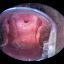

In [11]:
show(train_data[0])

In [12]:
test_data = np.load('ALL_TEST_NOSEG_64.npy')

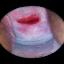

In [13]:
show(test_data[0])

In [14]:
train = pd.read_csv('TRAIN.csv')

In [15]:
test = pd.read_csv('TEST.csv')

In [16]:
le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)
print(le.classes_)

['Type_1' 'Type_2' 'Type_3']


In [17]:
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split

batch_size = 32
num_classes = 3
epochs = 10
data_augmentation = True

In [18]:
x_train, x_val_train, y_train, y_val_train =\
train_test_split(train_data, train_target, test_size=0.4, random_state=17)

In [19]:
x_train.shape, x_val_train.shape, y_train.shape, y_val_train.shape

((4927, 64, 64, 3), (3285, 64, 64, 3), (4927,), (3285,))

In [20]:
num_classes = 3
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val_train = keras.utils.to_categorical(y_val_train, num_classes)

In [54]:
# Basic Model 
model = Sequential()
model.add(Reshape((64,64,3), input_shape=x_train.shape[1:]))
model.add(Conv2D(4, (3, 3), padding='same',data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Conv2D(8, (3, 3), padding='same',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(12))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 4)         112       
_________________________________________________________________
activation_9 (Activation)    (None, 64, 64, 4)         0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 8)         296       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 8)         0         
__________

In [25]:
model = Sequential()
model.add(Reshape((64,64,3), input_shape=x_train.shape[1:]))
model.add(Conv2D(4, (3, 3), padding='same',data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.5))

model.add(Conv2D(8, (3, 3), padding='same',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.5))

model.add(Conv2D(16, (3, 3), padding='same',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 4)         112       
_________________________________________________________________
activation_21 (Activation)   (None, 64, 64, 4)         0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 4)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 8)         296       
_________________________________________________________________
activation_22 (Activation)   (None, 32, 32, 8)         0         
__________

In [26]:
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(optimizer = 'adamax', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [27]:
x_train = x_train.astype('float32')
x_val_train = x_val_train.astype('float32')

x_train /= 255
x_val_train /= 255

x_test = test_data.astype('float32')
x_test /= 255

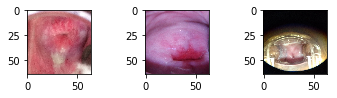

In [28]:
for i in range(0, 3):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[0:10][i])#, cmap = pyplot.get_cmap('gray'))
pyplot.show()

(64, 64, 3)


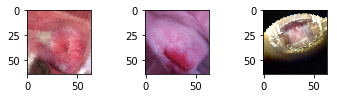

In [100]:
# rotation_range：整数，增加數據，隨機旋轉角度
datagen = ImageDataGenerator(rotation_range = 180,\
                             data_format="channels_last")

datagen.fit(x_train[0:3])
p_train_X, p_train_Y = datagen.flow(x_train[0:3], x_val_train[0:3],\
                                    batch_size = 4, shuffle = False).next()

assert (p_train_Y == x_val_train[0:3]).all()

for i in range(p_train_X.shape[0]):
    print(X_batch.shape)
    for i in range(0, 3):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(p_train_X[i]) #, cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    break

(64, 64, 3)


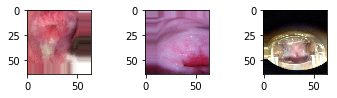

In [101]:
shift = 0.2 # 圖片的某個比例，可以水平或垂直移動圖片
datagen = ImageDataGenerator(width_shift_range = shift,\
                             height_shift_range = shift,\
                             data_format="channels_last")

datagen.fit(x_train[0:3])
p_train_X, p_train_Y = datagen.flow(x_train[0:3], x_val_train[0:3],\
                                    batch_size = 4, shuffle = False).next()

assert (p_train_Y == x_val_train[0:3]).all()

for i in range(p_train_X.shape[0]):
    print(X_batch.shape)
    for i in range(0, 3):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(p_train_X[i]) #, cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    break

(64, 64, 3)


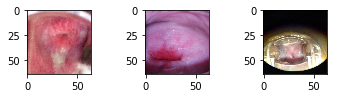

In [102]:
# 左右鏡射
datagen = ImageDataGenerator(horizontal_flip = True)#, vertical_flip=True)
datagen.fit(x_train[0:3])
p_train_X, p_train_Y = datagen.flow(x_train[0:3], x_val_train[0:3],\
                                    batch_size = 4, shuffle = False).next()

assert (p_train_Y == x_val_train[0:3]).all()

for i in range(p_train_X.shape[0]):
    print(X_batch.shape)
    for i in range(0, 3):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(p_train_X[i]) #, cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    break

(64, 64, 3)


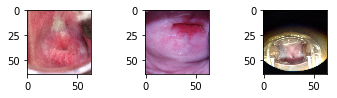

In [103]:
# 上下鏡射
datagen = ImageDataGenerator(vertical_flip = True)
datagen.fit(x_train[0:3])
p_train_X, p_train_Y = datagen.flow(x_train[0:3], x_val_train[0:3],\
                                    batch_size = 4, shuffle = False).next()

assert (p_train_Y == x_val_train[0:3]).all()

for i in range(p_train_X.shape[0]):
    print(X_batch.shape)
    for i in range(0, 3):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(p_train_X[i]) #, cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    break

In [45]:
# model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
#                         steps_per_epoch = x_train.shape[0],
#                         epochs = epochs,
#                         validation_data = (x_val_train, y_val_train))

In [30]:
# shift = 0.2
datagen = ImageDataGenerator(rotation_range = 180,\
                             horizontal_flip = True,\
                             vertical_flip = True,\
                             #width_shift_range=shift,\
                             #height_shift_range=shift,\
                             data_format = "channels_last")
datagen.fit(x_train)

In [31]:
model.fit_generator(datagen.flow(x_train, y_train,\
                                 batch_size = 32, shuffle = True),\
                    epochs = 200,\
                    samples_per_epoch = x_train.shape[0],\
                    verbose = 2,\
                    validation_data = (x_val_train, y_val_train))

/root/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=200, verbose=2, validation_data=(array([[[..., steps_per_epoch=153)`
  if __name__ == '__main__':


Epoch 1/200
9s - loss: 1.0049 - acc: 0.5229 - val_loss: 1.0286 - val_acc: 0.5263
Epoch 2/200
7s - loss: 0.9931 - acc: 0.5258 - val_loss: 1.0219 - val_acc: 0.5263
Epoch 3/200
7s - loss: 0.9856 - acc: 0.5287 - val_loss: 1.0004 - val_acc: 0.5266
Epoch 4/200
8s - loss: 0.9802 - acc: 0.5301 - val_loss: 1.0048 - val_acc: 0.5272
Epoch 5/200
8s - loss: 0.9773 - acc: 0.5334 - val_loss: 0.9974 - val_acc: 0.5279
Epoch 6/200
8s - loss: 0.9760 - acc: 0.5301 - val_loss: 0.9989 - val_acc: 0.5266
Epoch 7/200
8s - loss: 0.9699 - acc: 0.5351 - val_loss: 0.9868 - val_acc: 0.5257
Epoch 8/200
8s - loss: 0.9705 - acc: 0.5315 - val_loss: 0.9976 - val_acc: 0.5266
Epoch 9/200
8s - loss: 0.9712 - acc: 0.5310 - val_loss: 0.9855 - val_acc: 0.5266
Epoch 10/200
8s - loss: 0.9682 - acc: 0.5275 - val_loss: 0.9918 - val_acc: 0.5254
Epoch 11/200
8s - loss: 0.9638 - acc: 0.5309 - val_loss: 0.9975 - val_acc: 0.5263
Epoch 12/200
8s - loss: 0.9628 - acc: 0.5295 - val_loss: 0.9890 - val_acc: 0.5266
Epoch 13/200
8s - loss: 0

KeyboardInterrupt: 

In [39]:
pred = model.predict_proba(x_test)

 32/512 [>.............................] - ETA: 0s

In [40]:
df = pd.DataFrame(pred, columns=['Type_1','Type_2','Type_3'])

In [41]:
df['image_name'] = test_id

In [42]:
df = df[['image_name','Type_1','Type_2','Type_3']]

In [44]:
df.to_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/submission_LB1.csv', index=False)